In [1]:
#This notebook contains Upscaled LP-VAE implementation for both 120 ARC-AGI tasks. First few blocks define core components of network

import torch as t
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

In [2]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, inp_dim, embed_dim):
    super(PatchEmbedding, self).__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.total_patches = img_size / patch_size
    self.patchification_operation_i = t.nn.Conv2d(inp_dim, embed_dim, patch_size, stride = patch_size)
    self.patchification_operation_o = t.nn.Conv2d(inp_dim, embed_dim, patch_size, stride = patch_size)

  def forward(self, images_in_batch, input_only=False): #input_only mode will be used by decoder
    if input_only:
      patches_i_in_batch = self.patchification_operation_i(images_in_batch) # -> [batch_size, embded_dim, total_patches, total_patches]
      patches_i_in_batch = patches_i_in_batch.flatten(2)
      return patches_i_in_batch
    else:
      input_part = t.squeeze(images_in_batch[:,0,:,:,:])
      output_part = t.squeeze(images_in_batch[:,1,:,:,:])
      if input_part.dim() == 3:
        input_part = input_part.unsqueeze(1) #in case input dim is 1, sueeze operation above would end up geeting rid of that as well, hence need to bring it back
        output_part = output_part.unsqueeze(1)
      patches_i_in_batch = self.patchification_operation_i(input_part) # -> [batch_size, embded_dim, total_patches, total_patches]
      patches_i_in_batch = patches_i_in_batch.flatten(2)  # -> [batch_size, embded_dim, total_patches^2]
      patches_o_in_batch = self.patchification_operation_o(output_part) # -> [batch_size, embded_dim, total_patches, total_patches]
      patches_o_in_batch = patches_o_in_batch.flatten(2)  # -> [batch_size, embded_dim, total_patches^2]
      patches_in_batch = t.cat((patches_i_in_batch, patches_o_in_batch), 2) # -> [batch_size, embded_dim, 2*total_patches^2]
      print(patches_in_batch.size()) #[batchsize, channels, img_dim] standard conv2d output format hai pytorch me
      return patches_in_batch

In [3]:
class Attention(nn.Module):
  def __init__(self, embed_dim):
      super(Attention, self).__init__()
      self.W_q = t.nn.Linear(embed_dim,embed_dim, bias = False)
      self.W_k= t.nn.Linear(embed_dim,embed_dim, bias = False)
      self.W_v = t.nn.Linear(embed_dim,embed_dim, bias = False)

  def forward(self, patches_in_batch, perform_permute=False):
    if perform_permute:
      #nn.linear only considers the last dim hence permute
      Q = self.W_q(patches_in_batch.permute(0,2,1)) # -> [batch_size, 2*total_patches^2, embded_dim]
      K = self.W_k(patches_in_batch.permute(0,2,1))
      V = self.W_v(patches_in_batch.permute(0,2,1))
    else:
      Q = self.W_q(patches_in_batch)
      K = self.W_k(patches_in_batch)
      V = self.W_v(patches_in_batch)
    attention_W = t.matmul(Q, K.transpose(-2,-1))
    print(attention_W.size())
    print(t.sum(attention_W[1,1,:]))
    attention_W = attention_W.softmax(-1) # -> [batch_size, 2*total_patches^2, 2*total_patches^2]
    print(attention_W.size())

    contexualised_patches = t.matmul(attention_W, V)
    print(contexualised_patches.size())
    return contexualised_patches


In [51]:
class PositionalEmbedding(nn.Module): #three seperate embeddings for row, col, and whether the patch is from input/output
  def __init__(self, total_patches, embed_dim):
      super(PositionalEmbedding, self).__init__()
      self.row_embeds = nn.Embedding(int(total_patches), embed_dim)
      self.col_embeds = nn.Embedding(int(total_patches), embed_dim)
      self.io_embeds = nn.Embedding(2, embed_dim)
  def forward(self, total_patches):
    a = t.arange(0,total_patches)
    b = a.repeat(int(total_patches)).flatten().long()
    c = a.repeat_interleave(int(total_patches)).flatten().long()
    return [t.cat((self.col_embeds(b),self.col_embeds(b)),0), t.cat((self.row_embeds(c),self.row_embeds(c)),0), self.io_embeds(t.tensor([0,1]).repeat_interleave(int(total_patches*total_patches)).long())]

In [5]:
class ColourEmbedding(nn.Module): #For creating a unique embedding for each of the possible grid cell colours in ARC-AGI
  def __init__(self, embed_dim):
      super(ColourEmbedding, self).__init__()
      self.colour_embeds = nn.Embedding(10, embed_dim)
  def forward(self, cells):
    return self.colour_embeds(cells)

In [26]:
class DropPath(nn.Module): #randomly zeroes entire residual paths per sample
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + t.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

In [47]:
class BespokeVAE_Q(nn.Module): #Upscaled Encoder class. Set arc_mode to true
  def __init__(self, arc_mode=False, img_size_sqrt=30, patch_size=1):
    super(BespokeVAE_Q, self).__init__()
    self.arc_mode = arc_mode

    self.inp_dim = 1
    self.embed_dim = 48
    self.img_size = img_size_sqrt
    self.patch_size = patch_size
    self.total_patches = self.img_size / self.patch_size

    self.patch_embedding_model = PatchEmbedding(self.img_size, self.patch_size, self.inp_dim, self.embed_dim)
    self.positional_embeds_model = PositionalEmbedding(self.total_patches, self.embed_dim)

    self.norm_1 = nn.LayerNorm(self.embed_dim)
    self.attention_1 = Attention(self.embed_dim)

    self.embed_dim_2 = 24
    self.mlp_1 = nn.Linear(self.embed_dim,self.embed_dim_2,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_2]
    self.relu = nn.ReLU()
    self.norm_2 = nn.LayerNorm(self.embed_dim_2)
    self.attention_2 = Attention(self.embed_dim_2)

    self.drop_path_3  = DropPath(0.1)
    self.embed_dim_3 = 16
    self.mlp_2 = nn.Linear(self.embed_dim_2,self.embed_dim_3,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_3]
    self.norm_3 = nn.LayerNorm(self.embed_dim_3)
    self.attention_3 = Attention(self.embed_dim_3)

    self.drop_path_4  = DropPath(0.1)
    self.embed_dim_4 = 8
    self.mlp_3 = nn.Linear(self.embed_dim_3,self.embed_dim_4,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_4]
    self.norm_4 = nn.LayerNorm(self.embed_dim_4)
    self.attention_4 = Attention(self.embed_dim_4)

    self.drop_path_5  = DropPath(0.2)
    self.embed_dim_5 = 8
    self.mlp_4 = nn.Linear(self.embed_dim_4,self.embed_dim_5,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_5]
    self.norm_5 = nn.LayerNorm(self.embed_dim_5)
    self.attention_5 = Attention(self.embed_dim_5)

    self.drop_path_6  = DropPath(0.2)
    self.embed_dim_6 = 8
    self.mlp_5 = nn.Linear(self.embed_dim_5,self.embed_dim_6,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_6]
    self.norm_6 = nn.LayerNorm(self.embed_dim_6)
    self.attention_6 = Attention(self.embed_dim_6)

    self.drop_path_7  = DropPath(0.4)
    self.embed_dim_7 = 8
    self.mlp_6 = nn.Linear(self.embed_dim_6,self.embed_dim_7,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_6]
    self.norm_7 = nn.LayerNorm(self.embed_dim_7)
    self.attention_7 = Attention(self.embed_dim_7)

    self.latent_dim = 24
    self.mu = nn.Linear(int(2*self.total_patches*self.total_patches*self.embed_dim_4), self.latent_dim)
    self.sigma = nn.Linear(int(2*self.total_patches*self.total_patches*self.embed_dim_4) ,self.latent_dim)

  def forward(self, images_in_batch):
    if self.arc_mode:
      patch_embeds = images_in_batch
    else:
      print(images_in_batch) #[batch_size, 2, inp_channels, w, h]
      patch_embeds = self.patch_embedding_model(images_in_batch)
    positional_embeds = self.positional_embeds_model(self.total_patches)
    print(patch_embeds.size())
    patch_embeds = patch_embeds + positional_embeds[0].t() + positional_embeds[1].t() + positional_embeds[2].t()

    contexualised_patch_embeds_1 = self.relu(self.mlp_1(self.norm_1(patch_embeds.permute(0,2,1)) + self.attention_1(self.norm_1(patch_embeds.permute(0,2,1)).permute(0,2,1), True)))
    print(contexualised_patch_embeds_1.size())
    contexualised_patch_embeds_2 = self.relu(self.mlp_2(self.norm_2(contexualised_patch_embeds_1) + self.attention_2(self.norm_2(contexualised_patch_embeds_1))))
    contexualised_patch_embeds_3 = self.relu(self.mlp_3(self.norm_3(contexualised_patch_embeds_2) + self.drop_path_3(self.attention_3(self.norm_3(contexualised_patch_embeds_2)))))
    contexualised_patch_embeds_4 = self.relu(self.mlp_4(self.norm_4(contexualised_patch_embeds_3) + self.drop_path_4(self.attention_4(self.norm_4(contexualised_patch_embeds_3)))))
    contexualised_patch_embeds_5 = self.relu(self.mlp_5(self.norm_5(contexualised_patch_embeds_4) + self.drop_path_5(self.attention_5(self.norm_5(contexualised_patch_embeds_4)))))
    contexualised_patch_embeds_6 = self.relu(self.mlp_6(self.norm_6(contexualised_patch_embeds_5) + self.drop_path_6(self.attention_6(self.norm_6(contexualised_patch_embeds_5)))))
    contexualised_patch_embeds_7 = (self.norm_7(contexualised_patch_embeds_6) + self.drop_path_7(self.attention_7(self.norm_7(contexualised_patch_embeds_6)))).flatten(1)
    return [self.mu(contexualised_patch_embeds_7), self.sigma(contexualised_patch_embeds_7)]

In [30]:
class BespokeVAE_P(nn.Module): #Decoder
  def __init__(self, arc_mode, cross_entropy_mode = True, img_size_sqrt=30, patch_size=1):
    super(BespokeVAE_P, self).__init__()
    self.arc_mode = arc_mode
    self.batch_size = 20
    self.inp_dim = 1
    self.embed_dim = 48
    self.img_size = img_size_sqrt
    self.patch_size = patch_size
    self.total_patches = self.img_size / self.patch_size

    self.patch_embedding_model = PatchEmbedding(self.img_size, self.patch_size, self.inp_dim, self.embed_dim)
    self.attention_1 = Attention(self.embed_dim)
    self.embed_dim_2 = 16
    self.mlp_1 = nn.Linear(self.embed_dim,self.embed_dim_2,bias=True) # -> [batch_size, total_patches^2, embded_dim_2]
    self.relu = nn.ReLU()
    self.attention_2 = Attention(self.embed_dim_2)
    self.embed_dim_3 = 8
    self.mlp_2 = nn.Linear(self.embed_dim_2,self.embed_dim_3,bias=True) # -> [batch_size, total_patches^2, embded_dim_3]
    self.attention_3 = Attention(self.embed_dim_3)
    self.input_img_latent_dim = 128
    self.input_img_latent_mlp = nn.Linear(int(self.total_patches*self.total_patches*self.embed_dim_3), self.input_img_latent_dim)

    self.program_dim = 24
    if cross_entropy_mode:
      self.output_image_mlp = nn.Linear(self.program_dim  + self.input_img_latent_dim, self.img_size * self.img_size * 10)
    else:
      self.output_image_mlp = nn.Linear(self.program_dim  + self.input_img_latent_dim, self.img_size * self.img_size)

  def forward(self, images_in_batch, program): #[batch_size, inp_channels, w, h]
    if self.arc_mode:
      patch_embeds = images_in_batch
    else:
      print(images_in_batch)
      patch_embeds = self.patch_embedding_model(images_in_batch, True)

    contexualised_patch_embeds_1 = self.relu(self.mlp_1(self.attention_1(patch_embeds, True)))
    print(contexualised_patch_embeds_1.size())
    contexualised_patch_embeds_2 = self.relu(self.mlp_2(self.attention_2(contexualised_patch_embeds_1)))
    contexualised_patch_embeds_3 = self.attention_3(contexualised_patch_embeds_2).flatten(1)
    input_img_latent = self.input_img_latent_mlp(contexualised_patch_embeds_3)
    output_image = self.output_image_mlp(t.cat((input_img_latent, program), 1)) #takes as input the concatenation of program and inmput image latent (for each item in batch)
    print(t.cat((input_img_latent, program), 1).shape)
    return output_image

In [8]:
import json
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class ARCDataset(Dataset):
    def __init__(self, jsonl_paths):
        self.num_tasks = len(jsonl_paths)
        self.internal_task_offset = 0
        self.file_paths = []
        self.line_offsets = [[] for _ in range(self.num_tasks)]
        i = 0
        for jsonl_path in jsonl_paths:
          self.file_paths.append(jsonl_path)
          with open(jsonl_path, 'r', encoding='utf-8') as f:
              offset = 0
              for line in f:
                  self.line_offsets[i].append(offset)
                  offset += len(line.encode('utf-8'))
          i += 1

    def __len__(self):
        return 100000


    def pad_grid(self, grid): #Make gird size uniform to 30*30
        H, W = grid.shape
        pad_H = 30 - H
        pad_W = 30 - W
        padded = F.pad(grid, pad=(0, pad_W, 0, pad_H), mode='constant', value=0)
        return padded

    def __getitem__(self, idx):
        idx = idx % 1000
        with open(self.file_paths[self.internal_task_offset], 'r', encoding='utf-8') as f:
            f.seek(self.line_offsets[self.internal_task_offset][idx])
            line = f.readline()
            obj = json.loads(line)

        x = self.pad_grid(torch.tensor(obj['input']))
        y = self.pad_grid(torch.tensor(obj['output']))
        self.internal_task_offset += 1
        if self.internal_task_offset == self.num_tasks:
          self.internal_task_offset = 0
        return torch.stack((x, y), dim=0)


In [11]:
import os
folder_path = '/content/drive/MyDrive/ARC_ALL'

jsonl_file_paths = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith('.jsonl')
]

dataset = ARCDataset(jsonl_file_paths[:120])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=240, shuffle=True)

for egjample in dataloader:
    print(egjample.unsqueeze(2).shape)
    break

torch.Size([240, 2, 1, 30, 30])


In [32]:
def covariance_loss(mu, margin=1.0):
    batch_size = mu.size(0)
    dist_matrix = torch.cdist(mu, mu, p=2)  # euclidean distance

    # mask diagonal
    mask = ~torch.eye(batch_size, dtype=torch.bool, device=mu.device)
    dists = dist_matrix[mask]

    # penalize if too close (below margin)
    penalty = torch.clamp(margin - dists, min=0)
    return penalty.mean()


In [54]:
c = ColourEmbedding(48)
encoder = BespokeVAE_Q(arc_mode=True)
decoder = BespokeVAE_P(arc_mode=True)

optimizer = torch.optim.Adam(list(c.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_function = nn.CrossEntropyLoss(ignore_index=0)
losses_record = []
accuracies_record = []
i = 0
for examples in dataloader:
  print(len(examples))
  #print(c(egjample).permute(0,4,1,2,3).flatten(2).shape) #GOOD TO PASS IN ENCODER!
  optimizer.zero_grad()
  [mu, sigma] = encoder(c(examples[0:120,:,:,:]).permute(0,4,1,2,3).flatten(2))

  #LATENT OPTIMISATION!!
  mu_inner = mu.clone().detach().requires_grad_(True)
  optimizer_inner = torch.optim.Adam([mu_inner], lr=1e-3)
  for _ in range(0,4):
    optimizer_inner.zero_grad()
    decoded_img_inner = decoder(torch.flatten(c(examples[0:120,1]).permute(0,3,1,2), 2), mu_inner).view(-1, 900, 10)
    baseline_inner = torch.squeeze(examples[0:120,1,:,:]).flatten(1)
    loss_inner = loss_function(decoded_img_inner.reshape(-1, 10), baseline_inner.reshape(-1))
    repel_loss = covariance_loss(mu_inner)
    loss_inner += 0.5*repel_loss
    loss_inner.backward()
    optimizer_inner.step()

  #now prediction
  decoded_img = decoder(torch.flatten(c(torch.squeeze(examples[120:,1,:,:])).permute(0,3,1,2), 2), mu_inner).view(-1, 900, 10)
  #print(decoded_img.size())
  baseline = torch.squeeze(examples[120:,1,:,:]).flatten(1)
  loss = loss_function(decoded_img.reshape(-1, 10), baseline.reshape(-1))
  repel_loss = covariance_loss(mu)
  loss += 0.5*repel_loss
  loss.backward()
  optimizer.step()
  losses_record.append(loss.item())
  with torch.no_grad():
    preds = torch.argmax(decoded_img.reshape(-1, 10), dim=-1)
    baseline_flat = baseline.reshape(-1)
    valid_mask = baseline_flat != 0
    filtered_preds = preds[valid_mask]
    filtered_baseline = baseline_flat[valid_mask]
    accuracy = (filtered_preds == filtered_baseline).float().mean()
    accuracies_record.append(accuracy.item())
  i += 1
  if i == 50:
    break


Streaming output truncated to the last 5000 lines.
torch.Size([120, 900, 900])
tensor(-11.1829, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(-1.9250, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 8])
torch.Size([120, 152])
torch.Size([120, 900, 900])
tensor(3594.4031, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 48])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(-11.1829, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(-1.9250, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 8])
torch.Size([120, 152])
torch.Size([120, 900, 900])
tensor(3594.4031, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 48])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(-11.1829, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size

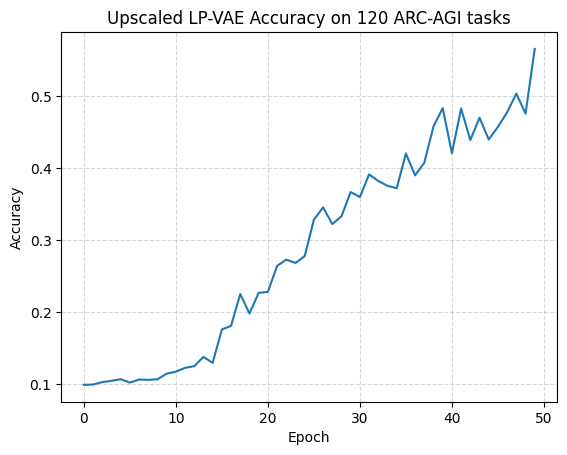

In [59]:
import matplotlib.pyplot as plt
plt.plot(accuracies_record)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Upscaled LP-VAE Accuracy on 120 ARC-AGI tasks")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [57]:
encoder.eval()
all_feats, all_labels = [], []
epochs = 0
with torch.no_grad():
    i = 0
    for examples in dataloader:
        feats = encoder(c(examples).permute(0,4,1,2,3).flatten(2))[0]
        all_feats.append(feats.cpu().numpy())
        a = np.arange(0,120).tolist()
        a.extend(a)
        all_labels.append(a)
        i += 1
        epochs += 1
        if epochs == 5:
          break
        if i == 3:
          i = 0

X = np.concatenate(all_feats, axis=0)    # -> (N, D)
y = np.concatenate(all_labels, axis=0)   # -> (N,)

torch.Size([240, 48, 1800])
torch.Size([240, 1800, 1800])
tensor(-5319.8403)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 48])
torch.Size([240, 1800, 24])
torch.Size([240, 1800, 1800])
tensor(-1257.9846)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 24])
torch.Size([240, 1800, 1800])
tensor(1096.9429)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 16])
torch.Size([240, 1800, 1800])
tensor(-626.8374)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 8])
torch.Size([240, 1800, 1800])
tensor(1221.0509)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 8])
torch.Size([240, 1800, 1800])
tensor(3655.4065)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 8])
torch.Size([240, 1800, 1800])
tensor(492.1887)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 8])
torch.Size([240, 48, 1800])
torch.Size([240, 1800, 1800])
tensor(-3138.0818)
torch.Size([240, 1800, 1800])
torch.Size([240, 1800, 48])
torch.Size([240, 1800, 24])
torch.Size([240, 1800, 1800])
tensor(-342.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


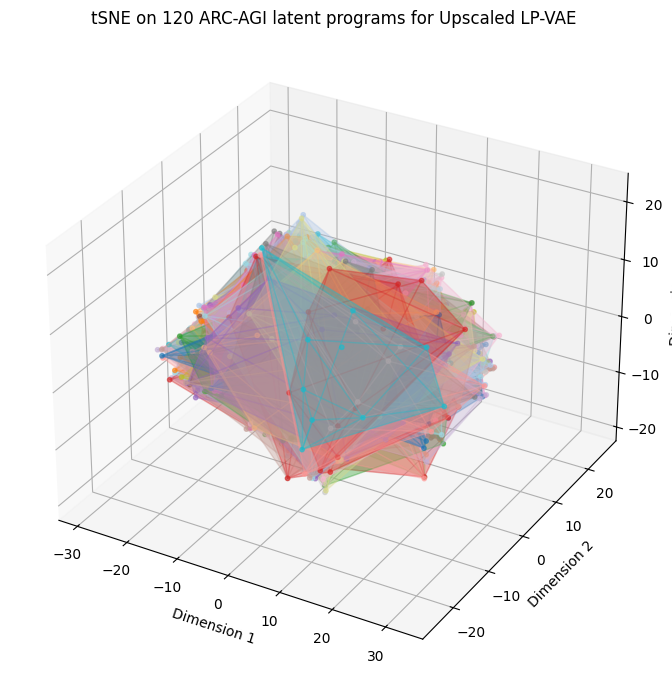

In [58]:
#tSNE plot
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.manifold import TSNE

tsne3 = TSNE(
    n_components=3,
    init="pca",
    perplexity=min(5, len(X)-1),  # keep < N
    n_iter=1000,
    random_state=42
)
X3 = tsne3.fit_transform(X)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap("tab20", len(np.unique(y)))

for idx, cls in enumerate(np.unique(y)):
    pts = X3[y == cls]
    color = cmap(idx)

    ax.scatter(pts[:,0], pts[:,1], pts[:,2], color=color, s=10, alpha=0.6)

    if pts.shape[0] >= 4:
        hull = ConvexHull(pts)
        faces = hull.simplices
        mesh = Poly3DCollection(
            [pts[face] for face in faces],
            facecolor=color, alpha=0.2, edgecolor=color
        )
        ax.add_collection3d(mesh)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
ax.set_title("tSNE on 120 ARC-AGI latent programs for Upscaled LP-VAE")
plt.tight_layout()
plt.show()

# Ablation Test 1 - disable TTO

In [67]:
c = ColourEmbedding(48)
encoder = BespokeVAE_Q(arc_mode=True)
decoder = BespokeVAE_P(arc_mode=True)

optimizer = torch.optim.Adam(list(c.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_function = nn.CrossEntropyLoss(ignore_index=0)
losses_record = []
accuracies_record = []
i = 0
for examples in dataloader:
  print(len(examples))
  #print(c(egjample).permute(0,4,1,2,3).flatten(2).shape) #GOOD TO PASS IN ENCODER!
  optimizer.zero_grad()
  [mu, sigma] = encoder(c(examples[0:120,:,:,:]).permute(0,4,1,2,3).flatten(2))

  #now prediction
  decoded_img = decoder(torch.flatten(c(torch.squeeze(examples[120:,1,:,:])).permute(0,3,1,2), 2), mu_inner).view(-1, 900, 10)
  #print(decoded_img.size())
  baseline = torch.squeeze(examples[120:,1,:,:]).flatten(1)
  loss = loss_function(decoded_img.reshape(-1, 10), baseline.reshape(-1))
  repel_loss = covariance_loss(mu)
  loss += 0.5*repel_loss
  loss.backward()
  optimizer.step()
  losses_record.append(loss.item())
  with torch.no_grad():
    preds = torch.argmax(decoded_img.reshape(-1, 10), dim=-1)
    baseline_flat = baseline.reshape(-1)
    valid_mask = baseline_flat != 0
    filtered_preds = preds[valid_mask]
    filtered_baseline = baseline_flat[valid_mask]
    accuracy = (filtered_preds == filtered_baseline).float().mean()
    accuracies_record.append(accuracy.item())
  i += 1
  if i == 50:
    break


240
torch.Size([120, 48, 1800])
torch.Size([120, 1800, 1800])
tensor(2062.1638, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 48])
torch.Size([120, 1800, 24])
torch.Size([120, 1800, 1800])
tensor(543.6675, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 24])
torch.Size([120, 1800, 1800])
tensor(1857.6736, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 16])
torch.Size([120, 1800, 1800])
tensor(2200.0688, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 8])
torch.Size([120, 1800, 1800])
tensor(-1019.4098, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 8])
torch.Size([120, 1800, 1800])
tensor(730.3907, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 8])
torch.Size([120, 1800, 1800])
tensor(858.8550, grad_fn=<SumBackward0>)
torch.Size([120, 1800, 1800])
torch.Size([120, 1800, 8])
torch.Size([120, 900, 900])
tensor(7

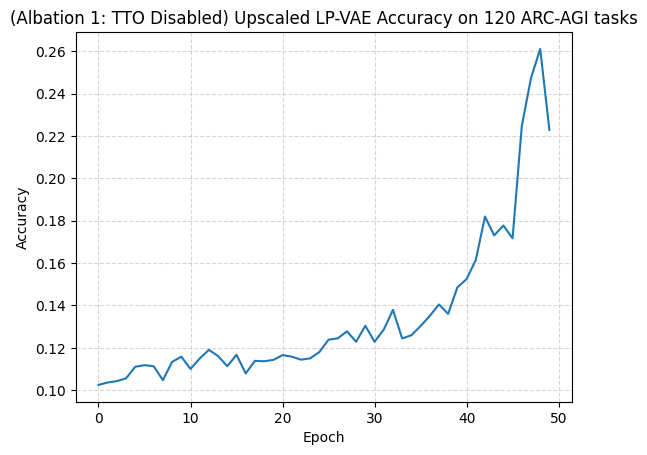

In [68]:
import matplotlib.pyplot as plt
plt.plot(accuracies_record)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("(Albation 1: TTO Disabled) Upscaled LP-VAE Accuracy on 120 ARC-AGI tasks")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Ablation Test 2: TTO but no LP

In [63]:
c = ColourEmbedding(48)
encoder = BespokeVAE_Q(arc_mode=True)
decoder = BespokeVAE_P(arc_mode=True)

optimizer = torch.optim.Adam(list(c.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_function = nn.CrossEntropyLoss(ignore_index=0)
losses_record = []
accuracies_record = []
i = 0
for examples in dataloader:
  print(len(examples))
  #print(c(egjample).permute(0,4,1,2,3).flatten(2).shape) #GOOD TO PASS IN ENCODER!
  optimizer.zero_grad()
  [mu, sigma] = encoder(c(torch.cat([examples[:120, 0, :, :].unsqueeze(1), examples[:120, 0, :, :].unsqueeze(1)], dim=1)).permute(0,4,1,2,3).flatten(2))

  #LATENT OPTIMISATION!!
  mu_inner = mu.clone().detach().requires_grad_(True)
  optimizer_inner = torch.optim.Adam([mu_inner], lr=1e-3)
  for _ in range(0,4):
    optimizer_inner.zero_grad()
    decoded_img_inner = decoder(torch.flatten(c(examples[0:120,1]).permute(0,3,1,2), 2), mu_inner).view(-1, 900, 10)
    baseline_inner = torch.squeeze(examples[0:120,1,:,:]).flatten(1)
    loss_inner = loss_function(decoded_img_inner.reshape(-1, 10), baseline_inner.reshape(-1))
    repel_loss = covariance_loss(mu_inner)
    loss_inner += 0.5*repel_loss
    loss_inner.backward()
    optimizer_inner.step()

  #now prediction
  decoded_img = decoder(torch.flatten(c(torch.squeeze(examples[120:,1,:,:])).permute(0,3,1,2), 2), mu_inner).view(-1, 900, 10)
  #print(decoded_img.size())
  baseline = torch.squeeze(examples[120:,1,:,:]).flatten(1)
  loss = loss_function(decoded_img.reshape(-1, 10), baseline.reshape(-1))
  repel_loss = covariance_loss(mu)
  loss += 0.5*repel_loss
  loss.backward()
  optimizer.step()
  losses_record.append(loss.item())
  with torch.no_grad():
    preds = torch.argmax(decoded_img.reshape(-1, 10), dim=-1)
    baseline_flat = baseline.reshape(-1)
    valid_mask = baseline_flat != 0
    filtered_preds = preds[valid_mask]
    filtered_baseline = baseline_flat[valid_mask]
    accuracy = (filtered_preds == filtered_baseline).float().mean()
    accuracies_record.append(accuracy.item())
  i += 1
  if i == 50:
    break


Streaming output truncated to the last 5000 lines.
torch.Size([120, 900, 900])
tensor(-49.2365, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(0., grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 8])
torch.Size([120, 152])
torch.Size([120, 900, 900])
tensor(2103.7126, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 48])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(-49.2365, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(0., grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 8])
torch.Size([120, 152])
torch.Size([120, 900, 900])
tensor(2103.7126, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900, 48])
torch.Size([120, 900, 16])
torch.Size([120, 900, 900])
tensor(-49.2365, grad_fn=<SumBackward0>)
torch.Size([120, 900, 900])
torch.Size([120, 900

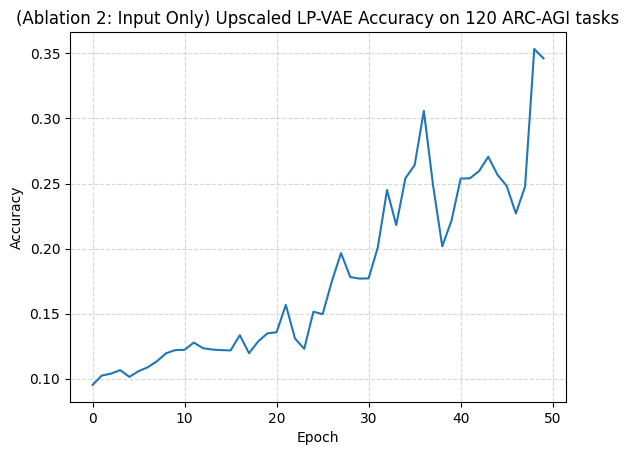

In [65]:
import matplotlib.pyplot as plt
plt.plot(accuracies_record)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("(Ablation 2: Input Only) Upscaled LP-VAE Accuracy on 120 ARC-AGI tasks")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()